In [167]:
import numpy as np 

In [168]:
# with open("./faces", 'r') as file:
#     lines = file.readlines()[19:-4]
#     data = []
#     for line in lines:
#         # 替换'4(28 617 618 29)\n'中的括号与空格为逗号
#         line = line.strip().replace("(", " ").replace(")", " ").split()
#         # 替换['4', '28', '617', '618', '29']当中字符串为数字
#         line = [int(l) for l in line]
#         data.append(line)
#     data = np.array(data)
# data

In [169]:
# line = lines[19].strip().replace("(", " ").replace(")", " ").split()
# line = [int(l) for l in line]
# line

In [170]:
def convert_data(path:str, line_start:int, line_end:int=-4, num_type:str="int") -> np.array:
    """
    path:文件路径,
    line_start:数字开始行,
    line_end:数字结束行,
    num_type:数字类型,
    """
    num_type_dict = {
        "int":int,
        "float":float,
    }
    with open(path, 'r') as file:
        lines = file.readlines()[line_start:line_end]
        data = []
        for line in lines:
            # 替换'4(28 617 618 29)\n'中的括号与空格为逗号
            line = line.strip().replace("(", " ").replace(")", " ").split()
            # 替换['4', '28', '617', '618', '29']当中字符串为数字
            line = [num_type_dict[num_type](l) for l in line]
            data.append(line)
        data = np.array(data)
    return data 

In [171]:
faces = convert_data("./faces", 19)

In [172]:
neighbour = convert_data("./neighbour", 20)

In [173]:
owner = convert_data("./owner", 20)

In [174]:
points = convert_data("./points", 19, num_type="float")
points = points * 1000

In [175]:
boundary = {  
    "inlet": {  
        "type": "patch",  
        "nFaces": 30,  
        "startFace": 24170  
    },  
    "outlet": {  
        "type": "patch",  
        "nFaces": 57,  
        "startFace": 24200  
    },  
    "upperWall": {  
        "type": "wall",  
        "inGroups": "List<word> 1(wall)",  
        "nFaces": 223,  
        "startFace": 24257  
    },  
    "lowerWall": {  
        "type": "wall",  
        "inGroups": "List<word> 1(wall)",  
        "nFaces": 250,  
        "startFace": 24480  
    },  
    "frontAndBack": {  
        "type": "empty",  
        "inGroups": "List<word> 1(empty)",  
        "nFaces": 24450,  
        "startFace": 24730  
    }  
}

In [176]:
class Node():
    def __init__(
            self, 
            centriod:np.array=np.zeros(3), # 节点形心坐标，即节点的坐标x,y,z
            index:int=0,  # 节点整体标识（编号，编码）
            iFaces:np.array=np.zeros(3), # 节点被哪些面所享有，这些面的标识列表
            iElement:np.array=np.zeros(3), # 节点被哪些单元所享有，这些单元的标识列表
            ) -> None:
        self.centriod = centriod
        self.index = index
        self.iFaces = iFaces
        self.iElement = iElement 
class Face():
    def __init__(
            self, 
            iNodes:np.array=np.zeros(3), # 构成该面的节点列表
            index:int=0, # 该面的标识
            iOwner:int=0, # 该面owner单元标识
            iNeighbour:int=0, # 该面neighbour单元标识（若为边界面，则该标识为-1）
            centriod:np.array=np.zeros(3), # 该面形心坐标x,y,z
            Sf:np.array=np.zeros(3), # 该面的面积矢量Sx,Sy,Sz
            area:float=0.0, # 该面的面积S
            Cf:np.array=np.zeros(3), # 该面所属单元形心到该面形心的距离矢量Cf
            geoDiff:float=0.0, # 面几何扩散系数 gDiff_f = Ef / CF
            T:np.array=np.zeros(3), # 面所属单元和邻近单元形心之间的距离矢量CF？（感觉更像是Tf=Sf-CF为非正交修正矢量，见第8章内容）
            gf:float=0.0, # 面插值中的几何权重系数gf
            walldist:int=0, # 面所属单元形心到壁面的垂直距离（某些湍流模型中会用到）
            iOwnerNeighbourCoef:np.array=np.array([0]), # ?
            iNeighbourOwnerCoef:np.array=np.array([0]), # ?
            ):        
        self.iNodes = iNodes
        self.index = index
        self.iOwner = iOwner 
        self.iNeighbour = iNeighbour
        self.centriod = centriod
        self.Sf = Sf 
        self.area = area 
        self.Cf = Cf 
        self.geoDiff = geoDiff 
        self.T = T 
        self.gf = gf 
        self.walldist = walldist
        self.iOwnerNeighbourCoef = iOwnerNeighbourCoef
        self.iNeighbourOwnerCoef = iNeighbourOwnerCoef
    # def initialize_data(self):
class Element():
    def __init__(
            self,
            index:int=0, # 该单元标识
            iNeighbour:np.array=np.zeros(3), # 该单元的邻近单元（与该单元共享面的那些单元）标识列表
            iFaces:np.array=np.zeros(3), # 构成该单元的面标识列表
            iNodes:np.array=np.zeros(3), # 构成该单元的节点标识列表
            volume:float=0.0, # 该单元体积
            faceSign:np.array=np.zeros(3), # 该单元的构成面是否为其owner面（==1）或neighbour（==-1）
            numberOfNeighbour:int=0, # 该单元邻近单元数目
            centroid:np.array=np.zeros(3), # 该单元的形心坐标x,y,z
            ):
        self.index = index 
        self.iNeighbour = iNeighbour
        self.iFaces = iFaces 
        self.iNodes = iNodes 
        self.volume = volume 
        self.faceSign = faceSign 
        self.numberOfNeighbour = numberOfNeighbour
        self.centroid = centroid
class Boundary():
    def __init__(
            self,
            userName:str=None,
            index:int=0,
            type_:str=None,
            numberOfBFaces:int=0,
            startFace:int=0,
            ) -> None:
        self.userName = userName 
        self.index = index 
        self.type = type_ 
        self.numberOfBFaces = numberOfBFaces
        self.startFace = startFace

In [177]:
x = np.zeros(faces.shape)  
y = np.zeros(faces.shape)  
z = np.zeros(faces.shape) 
count_row = 0
for face in faces[:, 1:]:
    count_col = 0
    for f in face:
        x[count_row,count_col] = points[f][0]
        y[count_row,count_col] = points[f][1]
        z[count_row,count_col] = points[f][2]
        count_col = count_col + 1
    count_row += 1
# 让首尾的点位相连
x[:, -1] = x[:, 0]
y[:, -1] = y[:, 0]
z[:, -1] = z[:, 0]

faces= [  4   0 589 608  19]
x= [-20.6 -20.6 -20.6 -20.6 -20.6]
y= [0.        0.        0.3188406 0.3188406 0.       ]
z= [-0.5  0.5  0.5 -0.5 -0.5]
上面~=下面，则上面代码有误
--------x--------y--------z-------
[-20.6   0.   -0.5]
[-20.6   0.    0.5]
[-20.6         0.3188406   0.5      ]
[-20.6         0.3188406  -0.5      ]


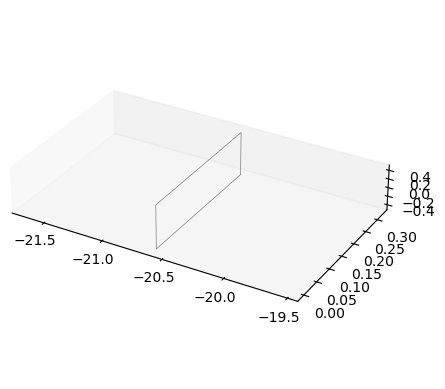

In [178]:
def test_xyz(num):
    print("faces=",faces[num])
    print("x=",x[num])
    print("y=",y[num])
    print("z=",z[num])
    print("上面~=下面，则上面代码有误")
    print("--------x--------y--------z-------")
    for i in faces[num][1:]:
        print(points[i])
    from matplotlib import pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.grid(False)
    ax.plot3D(x[num], y[num], z[num], 'gray', linewidth=0.5)
    plt.gca().set_box_aspect((25,15,4))
test_xyz(24170)

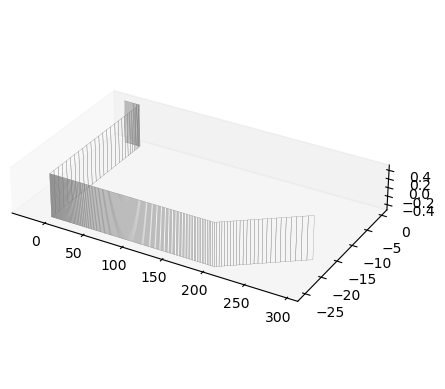

In [203]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.grid(False)

boundary_type = "lowerWall"
# for i in range(x.shape[0]):
for i in range(boundary[boundary_type]["startFace"], boundary[boundary_type]["startFace"]+boundary[boundary_type]["nFaces"]):
    ax.plot3D(x[i], y[i], z[i], 'gray', linewidth=0.2)
    plt.gca().set_box_aspect((25,15,4))
plt.savefig(f"./line_{boundary_type}.svg")

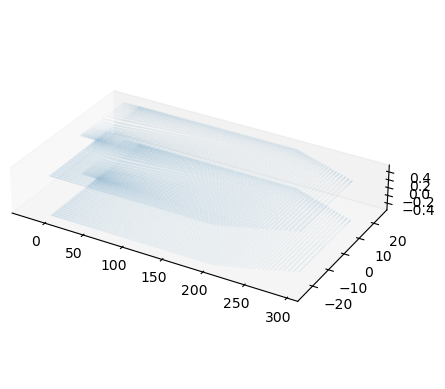

In [180]:
points_x = points[:, 0]
points_y = points[:, 1]
points_z = points[:, 2]
ax1 = plt.axes(projection='3d')
ax1.grid(False)
ax1.scatter(points_x, points_y, points_z, s=0.001)
plt.gca().set_box_aspect((25,15,4))
plt.savefig("./scatter.svg")